# Chameleon 3D Simulation (III)
### Simulation without boundary conditions at source surface -- Tu et al.
For meeting 6/22/2020

Yukei Murakami, UCB: sterling@astro.berkeley.edu

# Goals:


- learn how to create / import complicated geometry
- see if we can confirm any effect from source masses
- find issues with current method and move onto the next phase



# Model

## (0) Tu et al.


- pendulum rotation measurement

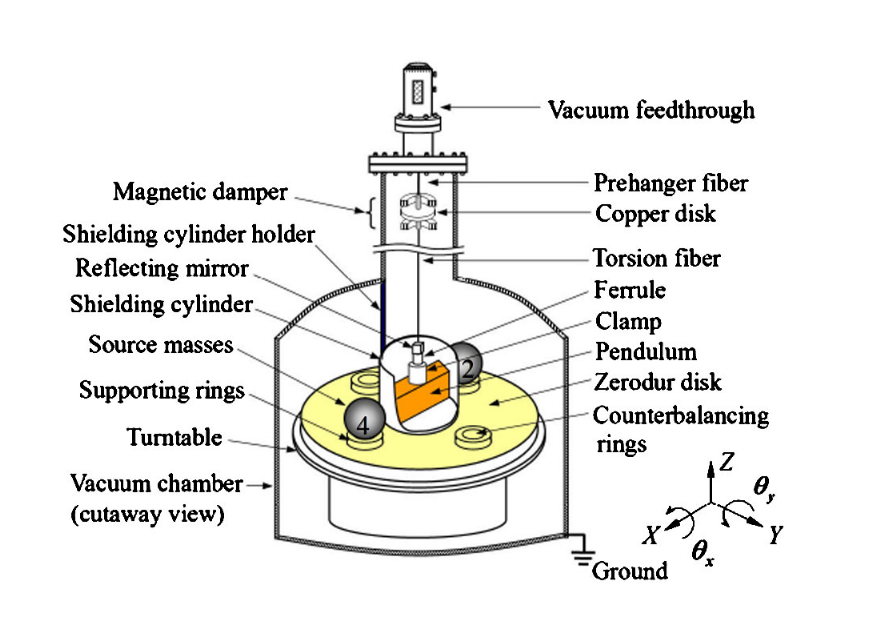

- geometry: the angle between pendulum and source masses affect on the angular velocity
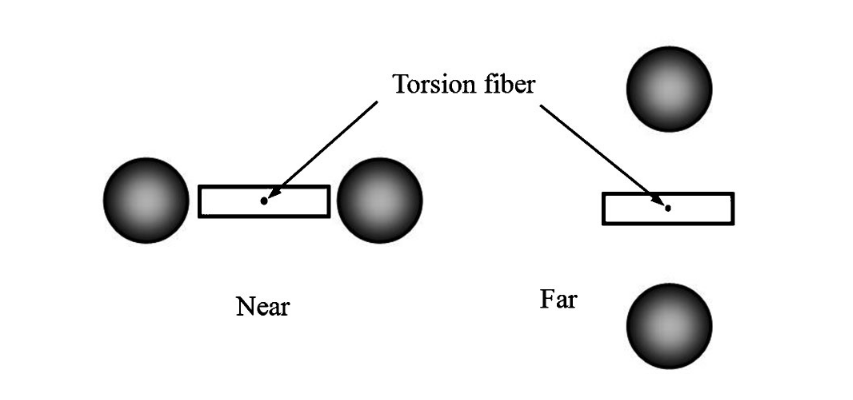

## (1) Our 3D model: simplified setup

![](img/gmsh_image.png)

It is important to make sure all objects are processed with boolean subtraction and boolean fragments.

### Cylinder (vacuum chamber)
- outer radius: 240mm
- inner radius: 225mm
- inner height: 500mm
- outer height: 520mm
- axis: z
- center of bottom circle: 0,0,0 (inner)

### shielding cylinder
> After the above measurements are finished, a 0.7-mm-
thick, 94-mm inner diameter, 90-mm-high, hollow gold-
coated aluminum cylinder is inserted between the pendu-
lum and the source masses (as shown in Fig. 3). (Tu et al. Section 9 "Electrostatic Shield")

- inner radius:50mm
- outer radius:51mm
- height:100mm

### source mass sphere
- radius: 26mm


## (2) domain numbering

vacuum chamber = 5<br>
spheres = 6<br>
cylinder = 7<br>
pendulum = 8<br>
vacuum space = 9

#  Simulation prep

In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import meshio
from datetime import datetime
from shutil import copyfile
import os

sns.set()

## Parameters

In [2]:
rho_shpere_cgs = 778/(4/3*np.pi*(2.6**3))
rho_cylinder_cgs = 2.7

In [3]:
g_per_cm3_to_ev4 = 4.3 * 10**18
scaling = 1.97 * 10**-4

In [4]:
Lambda = 0.1 * 10**-3 # [eV]
Mpl    = 2.4 * 10**27 # [eV]
M      = 10**-3 * Mpl

In [5]:
R_sph = 10 # radius of internal sphere

In [6]:
rho_sphere = rho_shpere_cgs * g_per_cm3_to_ev4 
rho_cylinder = rho_cylinder_cgs * g_per_cm3_to_ev4
rho_outer = 7   * g_per_cm3_to_ev4 
rho_vacuum = 6.6 * 10**-17  * g_per_cm3_to_ev4

outer_phi_eq = np.sqrt(Lambda**5 * M / rho_outer)

## Functions & Classes

In [7]:
def solve(V,rho_solve,bcs,phi,max_iterations=200,relative_tolerance=1e-9):
    v = fn.TestFunction(V)
    f = Lambda**5/phi**2
    g = fn.Constant(0)
    a = (fn.inner(fn.grad(phi)*scaling**2,fn.grad(v))+ rho_solve*v/M)/scaling*fn.dx
    L = f*v/scaling*fn.dx + g*v*fn.ds
    F = a-L   
    J = fn.derivative(F, phi)
    problem = fn.NonlinearVariationalProblem(F,phi,bcs,J)
    solver = fn.NonlinearVariationalSolver(problem)
    prm = solver.parameters
    prm["newton_solver"]["linear_solver"] = "mumps"
    prm["newton_solver"]["report"] = True
    prm["newton_solver"]["relative_tolerance"] = relative_tolerance
    prm["newton_solver"]["maximum_iterations"] = max_iterations
    
    time = datetime.now().strftime("%H:%M:%S")
    print("["+time+"] Simulation started")
    solver.solve()
    time = datetime.now().strftime("%H:%M:%S")
    print("["+time+"] Simulation finished")    

    return phi

In [8]:
def convertMesh(mshfile):
    ## original mesh file
    msh = meshio.read(mshfile)

    ## physical surface & volume data
    for key in msh.cell_data_dict["gmsh:physical"].keys():
        if key == "triangle":
            triangle_data = msh.cell_data_dict["gmsh:physical"][key]
        elif key == "tetra":
            tetra_data = msh.cell_data_dict["gmsh:physical"][key]

    ## cell data
    tetra_cells = np.array([None])
    triangle_cells = np.array([None])
    for cell in msh.cells:
        if cell.type == "tetra":
            if tetra_cells.all() == None:
                tetra_cells = cell.data
            else:
                tetra_cells = np.concatenate((tetra_cells,cell.data))
        elif cell.type == "triangle":
            if triangle_cells.all() == None:
                triangle_cells = cell.data
            else:
                triangle_cells = np.concatenate((triangle_cells,cell.data))

    ## put them together
    tetra_mesh = meshio.Mesh(points=msh.points, 
                             cells={"tetra": tetra_cells},
                             cell_data={"name_to_read":[tetra_data]})
    triangle_mesh =meshio.Mesh(points=msh.points,
                               cells=[("triangle", triangle_cells)],
                               cell_data={"name_to_read":[triangle_data]})
    
    ## output
    if not os.path.exists('output/tmp'):
        os.makedirs('output/tmp')
    meshio.write("output/tmp/mesh.xdmf", tetra_mesh)
    meshio.write("output/tmp/mf.xdmf", triangle_mesh)

In [9]:
def importMesh(meshfile="output/tmp/mesh.xdmf",mffile="output/tmp/mf.xdmf"):
    ## Import mesh
    mesh = fn.Mesh()
    with fn.XDMFFile(meshfile) as infile: 
        infile.read(mesh)
        
    ## Import material info (physical volume)
    mvc = fn.MeshValueCollection("size_t", mesh, 2)
    with fn.XDMFFile(meshfile) as infile: 
        infile.read(mvc, "name_to_read")
    materials = fn.cpp.mesh.MeshFunctionSizet(mesh, mvc)

    ## Import boundary info (physical surface)
    mvc = fn.MeshValueCollection("size_t", mesh, 2)
    with fn.XDMFFile(mffile) as infile: 
        infile.read(mvc, "name_to_read")
    boundaries = fn.cpp.mesh.MeshFunctionSizet(mesh, mvc)
    
    ## function, etc.
    dx = fn.Measure('dx', domain=mesh, subdomain_data=mvc)
    V = fn.FunctionSpace(mesh, 'CG', 1)
    
    return mesh,materials,boundaries,dx,V

In [10]:
class Rho(fn.UserExpression):
    def __init__(self,materials,volume_list,rho_list,**kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.volume_list = volume_list
        self.rho_list = rho_list
    def value_shape(self):
        return ()
    def eval_cell(self,values,x,cell):
        values[0] = 0
        for i in range(len(self.volume_list)):
            if self.materials[cell.index] == self.volume_list[i]:
                values[0] = self.rho_list[i]            

# Simulation

In [11]:
####  (1) Import mesh ####
meshfile = 'models/Tu_001.msh'
convertMesh(meshfile)
mesh,materials,boundaries,dx,V = importMesh()

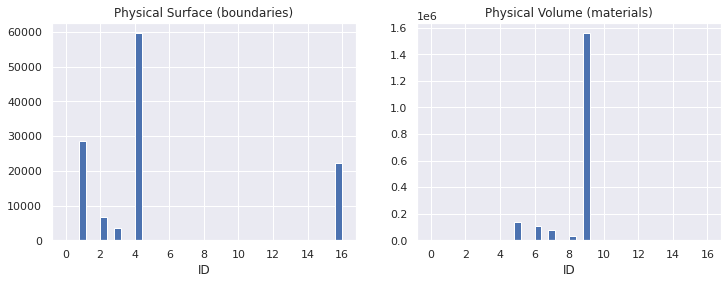

In [12]:
####  (2) Physical Region Info ###
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.hist(boundaries.array(),range=(0,16),bins=40)
ax1.set_title('Physical Surface (boundaries)')
ax1.set_xlabel('ID')
ax2.hist(materials.array(),range=(0,16),bins=40)
ax2.set_title('Physical Volume (materials)')
ax2.set_xlabel('ID');

In [13]:
#### (3) Boundary condition ####
outer_boundary = fn.DirichletBC(V, outer_phi_eq, boundaries, 16)
bcs = outer_boundary

#### NOTE: PENDULUM IS TREATED AS A VACUUM

In [14]:
#### (4) Material assignment ####
volume_list = [5,6,7,8,9]
rho_list    = [rho_outer,rho_sphere,rho_cylinder,rho_vacuum,rho_vacuum]
rho = Rho(materials,volume_list,rho_list,degree=0)

In [28]:
#### (5) Solve ####
phi = fn.project(outer_phi_eq,V,solver_type="mumps")
phi = solve(V,rho,bcs,phi,max_iterations=50,relative_tolerance=5e-9)

[18:48:26] Simulation started
[18:57:37] Simulation finished


In [52]:
phi = solve(V,rho,bcs,phi,max_iterations=50,relative_tolerance=5e-9)

[19:05:22] Simulation started


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  15b823f2c45d3036b6af931284d0f8e3c77b6845
*** -------------------------------------------------------------------------


In [53]:
####  (6) Save info ####
time = datetime.now().strftime("%b%d_%H%M%S")
fn.XDMFFile("output/"+time+"/materials.xdmf").write(materials)
fn.XDMFFile("output/"+time+"/boundaries.xdmf").write(boundaries)
fn.XDMFFile("output/"+time+"/rho.xdmf").write_checkpoint(fn.project(rho,V,solver_type="mumps"),'rho')
fn.XDMFFile("output/"+time+"/phi.xdmf").write_checkpoint(phi,'phi')
data3D = fn.File("output/"+time+"/phi.pvd")
data3D << phi
copyfile(meshfile,"output/"+time+"/mesh.msh")
copyfile("output/tmp/mesh.xdmf","output/"+time+"/mesh.xdmf")
copyfile("output/tmp/mesh.h5","output/"+time+"/mesh.h5")
copyfile("output/tmp/mf.xdmf","output/"+time+"/mf.xdmf")
copyfile("output/tmp/mf.h5","output/"+time+"/mf.h5")
print("Data files are successfully saved in output/"+time+"/.")

Data files are successfully saved in output/Jun18_225512/.


# Results

In [54]:
## prepare for importing data
import_folder = 'output/Jun18_225512/'
mesh2,_,_,_,V2 = importMesh(meshfile=import_folder+'mesh.xdmf',mffile=import_folder+'mf.xdmf')

In [55]:
## import functions (phi,rho)
phi2 = fn.Function(V2)
fn.XDMFFile(import_folder+"phi.xdmf").read_checkpoint(phi2,'phi')

## import mesh value collections (materials, boundaries)
# mvc = fn.MeshValueCollection("size_t", mesh2, 2)
# fn.XDMFFile(import_folder+"materials.xdmf").read(mvc)
# materials2 = fn.cpp.mesh.MeshFunctionSizet(mesh2, mvc)

## mesh & field images

![](output/Jun18_121916/Tu_001_mesh.png)

![](output/Jun18_121916/slice_closeup.png)

Text(0.5, 1.0, 'Projected model (normal to z)')

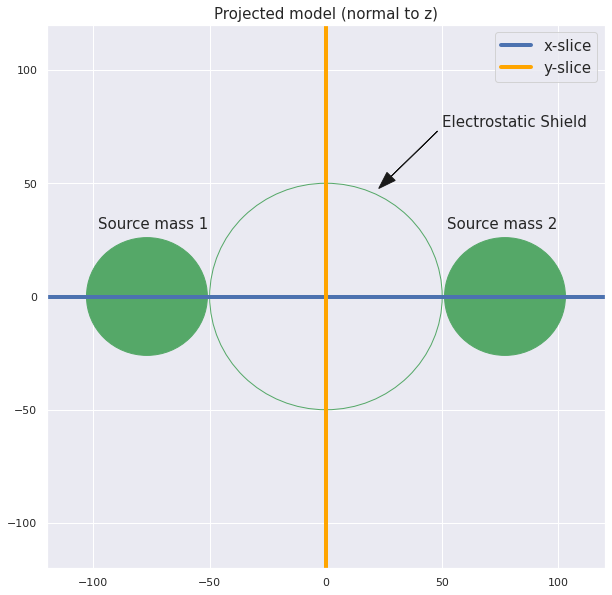

In [110]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.add_artist(plt.Circle((0, 0), 50, color='g',fill=False))
ax.add_artist(plt.Circle((77,0), 26, color='g'))
ax.add_artist(plt.Circle((-77,0), 26, color='g'))
ax.annotate(s='Source mass 2',xy=(52,30),fontsize=15)
ax.annotate(s='Source mass 1',xy=(-98,30),fontsize=15)
ax.annotate(s='Electrostatic Shield',xy=(50,75),fontsize=15)
ax.arrow(48,73,-20,-20,color='k',head_width=5)
ax.set_xlim(-120,120)
ax.set_ylim(-120,120)
ax.axhline(0,c='b',linewidth=4,label='x-slice')
ax.axvline(0,c='orange',linewidth=4,label='y-slice')
ax.legend(fontsize=15)
ax.set_title('Projected model (normal to z)',fontsize=15)

## plot functions

In [57]:
def plot_ynorm_at_z(phi,z_val):
    # prepare for plotting
    x = np.linspace(-239,239, 2000)
    y = np.zeros(len(x))
    z = np.full(len(x),z_val)
    coords = np.dstack((x, y, z))[0]
    cm = plt.get_cmap('winter_r')

    data1D = np.array(list(map(phi,coords)))
    plt.figure(figsize=(8,5))
    plt.title('Chameleon Field at z={}mm'.format(z_val))
    plt.xlabel('r [mm]')
    plt.ylabel(r'$\phi$ [meV]')
    plt.plot(coords[:,0],data1D*1000)
    plt.axvspan(51,103,label='source mass spheres (max radius)',color='orange',alpha=0.2)
    plt.axvspan(-51,-103,color='orange',alpha=0.2)
    plt.axvspan(50,51,label='shielding cylinder wall',color='green',alpha=0.5)
    plt.axvspan(-50,-51,color='green',alpha=0.5)
    plt.axvspan(225,240,label='vacuum chamber',color='red',alpha=0.2)
    plt.axvspan(-225,-240,color='red',alpha=0.2)

    plt.legend(bbox_to_anchor=(1,0.5))
    plt.show()

In [58]:
def plot_xnorm_at_z(phi,z_val,fig=None):
    # prepare for plotting
    y = np.linspace(-239,239, 2000)
    x = np.zeros(len(y))
    z = np.full(len(y),z_val)
    coords = np.dstack((x, y, z))[0]
    cm = plt.get_cmap('winter_r')

    data1D = np.array(list(map(phi,coords)))
    plt.figure(figsize=(8,5))
    plt.title('Chameleon Field at z={}mm'.format(z_val))
    plt.xlabel('r [mm]')
    plt.ylabel(r'$\phi$ [meV]')
    plt.plot(coords[:,1],data1D*1000)
    plt.axvspan(51,103,label='source mass spheres (max radius)',color='orange',alpha=0.2)
    plt.axvspan(-51,-103,color='orange',alpha=0.2)
    plt.axvspan(50,51,label='shielding cylinder wall',color='green',alpha=0.5)
    plt.axvspan(-50,-51,color='green',alpha=0.5)
    plt.axvspan(225,240,label='vacuum chamber',color='red',alpha=0.2)
    plt.axvspan(-225,-240,color='red',alpha=0.2)

    plt.legend(bbox_to_anchor=(1,0.5))
    plt.show()

In [59]:
def plot_xy_at_z(phi_3d,z_val,return_fig=False):
    # prepare figure
    fig,ax = plt.subplots(1,1,figsize=(8,5))
    plt.title('Chameleon Field at z={}mm'.format(z_val))
    plt.xlabel('r [mm]')
    plt.ylabel(r'$\phi$ [meV]')

    # plot: x-dir
    x = np.linspace(-239,239, 2000)
    y = np.zeros(len(x))
    z = np.full(len(x),z_val)
    coords = np.dstack((x, y, z))[0]
    data1D = np.array(list(map(phi_3d,coords)))
    plt.plot(coords[:,0],data1D*1000,label='along x-direction')

    # plot: y-dir
    y = np.linspace(-239,239, 2000)
    x = np.zeros(len(y))
    coords = np.dstack((x, y, z))[0]
    data1D = np.array(list(map(phi_3d,coords)))
    plt.plot(coords[:,1],data1D*1000,label='along y-direction')

    if np.max(data1D*1000)<1.0:
        ymin,ymax = ax.get_ylim()
        ax.set_ylim(ymin,1.0)
    
    # geometry
    plt.axvspan(51,103,label='source mass spheres (max radius)',color='orange',alpha=0.2)
    plt.axvspan(-51,-103,color='orange',alpha=0.2)
    plt.axvspan(50,51,label='shielding cylinder wall',color='green',alpha=0.5)
    plt.axvspan(-50,-51,color='green',alpha=0.5)
    plt.axvspan(225,240,label='vacuum chamber',color='red',alpha=0.2)
    plt.axvspan(-225,-240,color='red',alpha=0.2)
    plt.annotate(s='', xy=(-105,-0.025), xytext=(105,-0.025),color='k', 
                arrowprops={'arrowstyle':'<->','color':'k','linewidth':2,'shrinkA':0,'shrinkB':0})
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], color='k', lw=2, label='fine mesh region (results are more reliable)'))
    plt.legend(handles=handles,bbox_to_anchor=(1,0.5))
    if return_fig:
        return fig
    else:
        plt.show()

## plot

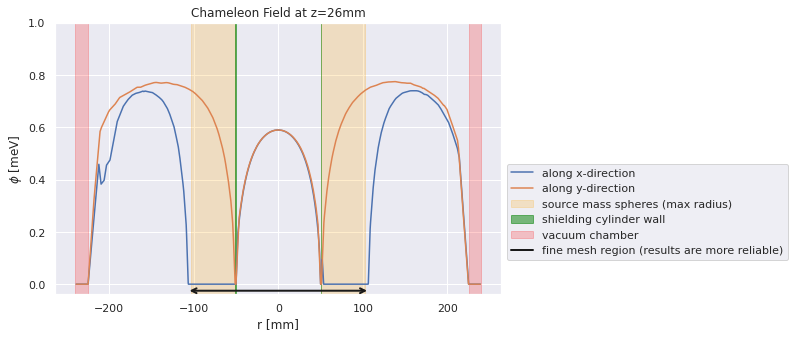

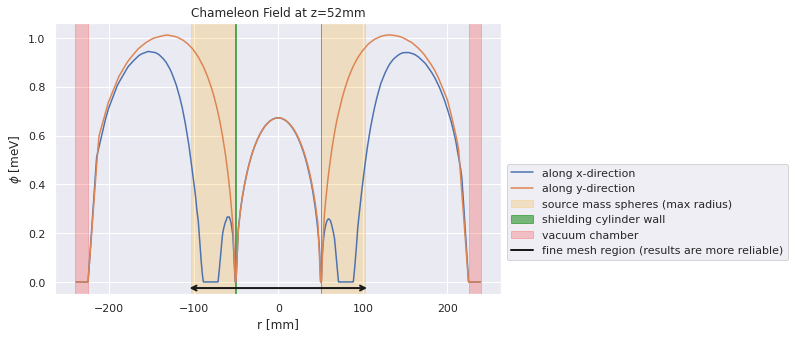

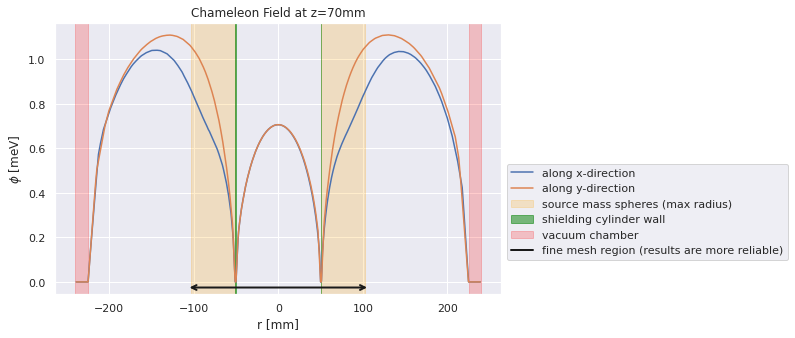

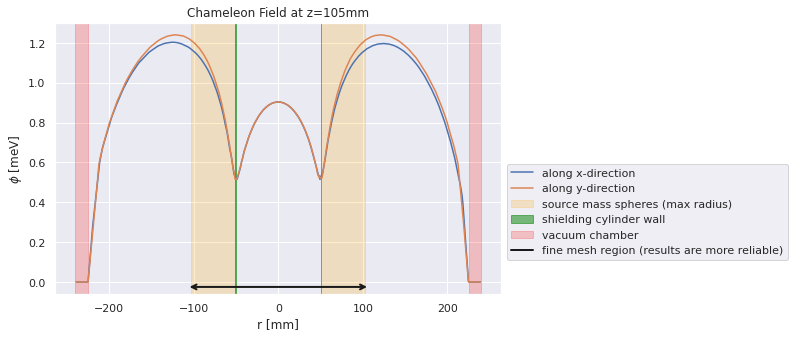

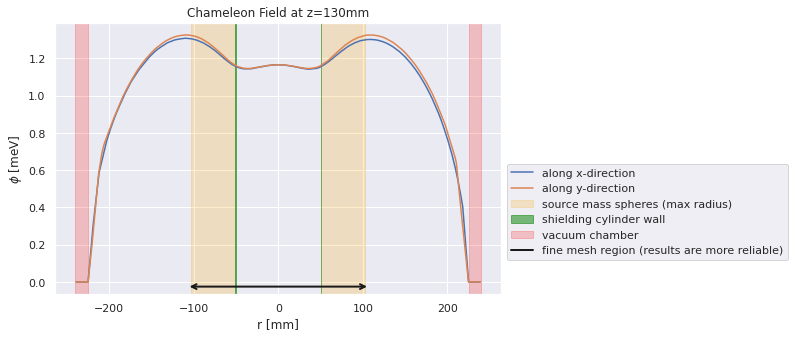

In [60]:
plot_xy_at_z(phi2,26)
plot_xy_at_z(phi2,52)
plot_xy_at_z(phi2,70)
plot_xy_at_z(phi2,105)
plot_xy_at_z(phi2,130)

In [ ]:
if not os.path.exists('output/animation/tmp'):
    os.makedirs('output/animation/tmp')
    
z_list = np.arange(1,300)
for z_val,i in zip(z_list,range(len(z_list))):
    fig = plot_xy_at_z(z_val,return_fig=True)
    plt.figure(fig.number)
    plt.savefig('output/animation/'+str(i).zfill(3)+'.png',dpi=100);

![](output/Jun18_154915/slice.gif)

## findings (quick note):

### (1) Geometry & Mesh
- The geometry does not involve the turntable and some other components (naive implementation)
- To obtain reasonable result, mesh had to be very dense (especially near the shielding cylinder)
- Locally refined region (near the source mass and the cylinder) is working well, but outer region requires finer meshing

### (2) Simulation
- With correct settings, simulation takes 15-30 min: heavily depends on cpu capability

### (3) Results
- Results suggest that even a 1mm-thick shield can screen the effect of source masses
- Since the force is measured by the pendulum's rotation speed, the only way Chameleon field contribute to this result is to have a non-uniform field at fixed z inside the electrostatic cylinder. Based on this simulation, that is not the case.